# Implementation Project of SciML Course Fall 2025 | Hsin-Pei Chen
## Constraints by Neural Networks on the Cosmic-Ray Ionization Rate of STARFORGE Simulations using UCLCHEM Models of H3+ and OH+

This repository contains the source code for an implementation project from the Scientific Machine Learning (SciML) course at The University of Texas at Austin (Instructor: Professor Krishna Kumar). The neural network code is open to the public to benefit the broader AI and astrophysics research communities. The network architecture follows Behrens et al. (2024), while the provided training dataset is based on UCLCHEM chemical models from my work (in prep.) and the STARFORGE simulations from Fitz Axen et al. (2024).

## Summary of the Behrens+2024-style MLP (Colab Implementation)

### **1. Data Loading**
- Two CSVs are read and merged by `ParticleID`.
- Inputs: `[nH, T, Ncol, CRIR]`
- Targets: `[H3+, OH+]`
- Converted to `torch.FloatTensor`.

---

### **2. Preprocessing**
- **Log10 Transform** -> this is **essential** because input/output parameters cover a wide range of order-of-magnitudes
  - Applied to inputs: `nH`, `Ncol`, `CRIR` (keep `T` linear).
  - Applied to outputs: (`H3+`, `OH+`).
- **Clipping**
  - Only log-transformed columns are clipped to `[−30, 30]`.
- **Standardization**
  - Compute `mean/std` on the **train split** only.
  - Standardize train/val/test with those stats.
- Helper functions:
  - `standardize()`, `destandardize()`, and `invert_y_to_original_space()`.

---

### **3. Diagnostics**
- **Corner Plot**
  - Fast `seaborn.PairGrid` + `hexbin` after log-transform.
  - Blue dashed clip lines mark `[−30, 30]` range.
- **Histograms**
  - Show each input & output distribution **after standardization**.

---

### **4. Splitting & Dataloaders**
- Shuffle: 60 % train / 15 % val / 25 % test.
- `DataLoader` (batch = 64):
  - Train: shuffled
  - Val/Test: not shuffled

---

### **5. Neural Network Architecture**
- **Input:** 4 features  
- **Hidden stack:** 4 × 2000 ReLU layers  
- **Output:** 2 nodes (H₃⁺, OH⁺)
- **Initialization:**
  - Kaiming (He) Uniform (fan_in) for ReLU layers  
  - Bias = 0  
- ≈ **12 M trainable parameters**

---

### **6. Training Setup**
- **Loss:** MSE on standardized log targets  
- **Optimizer:** Adam (lr = 1 × 10⁻³, β = 0.9/0.999)  
- **Scheduler:** ReduceLROnPlateau (factor = 0.5, patience = 5)  
- **Early Stopping:** patience = 20 epochs  
- **Mixed Precision:** `torch.amp.autocast("cuda")` + `GradScaler("cuda")`  
- **Device:** auto-select CUDA if available

---

### **7. Evaluation**
- Reports:
  - MSE (standardized space)
  - MSE + MAE (original space)
- **Parity Plots**
  - In **log₁₀ space**, after de-standardization.
  - Per-target scatter + R² annotation.

---

### **8. Saving & Inference**
- Save:
  - Model weights → `model.pth`
  - Normalization stats → `norm_stats.json`
- `predict_abundances(X_raw)`:
  - Applies identical preprocessing
  - Runs model in eval mode
  - Returns predictions in **original physical units**

---

### **9. Diagnostics (Optional Improvements)**
- Winsorize T (cap ≈ 99.5 %) to remove hot-tail outliers.  
- Derive per-target floors from the train split to prevent log(0).  
- Monitor clip fractions; large counts at −30 → too-low floor.

---


In [ ]:
import os, json, math, random, io
from dataclasses import dataclass
from typing import Dict, Tuple
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [ ]:
# -----------------------------
# Config & reproducibility
# -----------------------------
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DTYPE  = torch.float32

CFG = {
    "split": {"train": 0.60, "val": 0.15, "test": 0.25},
    "batch_size": 64,
    "max_epochs": 500,
    "early_stop_patience": 20,     # stop if no val improvement for 20 epochs
    "optim": {"lr": 1e-3, "betas": (0.9, 0.999), "weight_decay": 0.0},
    "scheduler": {"factor": 0.5, "patience": 5, "cooldown": 0, "min_lr": 1e-6},
    "paths": {"model": "./model.pth", "norm": "./norm_stats.json"},
    "clip_after_log": [-30.0, 30.0],
}

# IMPORTANT: Column order is [' nH (cm-3)', ' T (K)', ' Ncol (cm-2)', ' CRIR (s-1)']
# Apply log10 to nH, Ncol, CRIR; keep T linear
INPUT_LOG10_MASK = [True, False, True, True]

In [ ]:
# Data is stored in Google Drive (for submitted version, data will be provided)
# Run this block to connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# -----------------------------
# Load dataframes (check paths)
# -----------------------------
input_data_path = "/content/drive/MyDrive/12.ML/SciML_Implementation/"
output_data_path = "/content/drive/MyDrive/12.ML/SciML_Implementation/"
input_data_name = "Fiducial_snapshot_050_6D_filtered.csv"
output_data_name = "t1e6_sampled30000_frontera_final_abundances.csv"  # this is a test-size data

input_params  = pd.read_csv(os.path.join(input_data_path,  input_data_name),  sep=",", header=0)
output_params = pd.read_csv(os.path.join(output_data_path, output_data_name), sep=",", header=0)

input_features  = [' nH (cm-3)', ' T (K)', ' Ncol (cm-2)', ' CRIR (s-1)']  # Key params of the star forming cloud
output_targets  = ['H3+', 'OH+']  # species abundances

# The input dataset is the full data version, while the output (from UCLCHEM models) data can be in smaller size
# Match the input/output datasets by ParticleID (from the STARFORGE simulation)
matched = pd.merge(input_params, output_params, left_on='# ParticleID', right_on='ID', how='inner')
sampled_input_params  = matched[input_features].copy()
sampled_output_params = matched[output_targets].copy()

print("Shape of matched input parameters:", sampled_input_params.shape)
print("Shape of matched output parameters:", sampled_output_params.shape)

# Convert to tensors
X_df = sampled_input_params[input_features]
y_df = sampled_output_params[output_targets]
mask = (np.log10(y_df['H3+']) > -12) & (np.log10(y_df['OH+']) > -15)
X_df = X_df[mask]
y_df = y_df[mask]
x_train_tensor = torch.tensor(X_df.values, dtype=torch.float32)
u_train_tensor = torch.tensor(y_df.values, dtype=torch.float32)
print("Input tensor shape:", x_train_tensor.shape)
print("Output tensor shape:", u_train_tensor.shape)

Shape of matched input parameters: (30656, 4)
Shape of matched output parameters: (30656, 2)
Input tensor shape: torch.Size([15320, 4])
Output tensor shape: torch.Size([15320, 2])


In [ ]:
# -----------------------------
# Transforms (log10 + standardize)
# -----------------------------

# This is essential because input/output parameters cover a wide range of order-of-magnitudes

from dataclasses import dataclass
from typing import Tuple

@dataclass
class NormStats:
    x_mean: list
    x_std: list
    y_mean: list
    y_std: list
    x_log_mask: list  # which inputs were log-transformed
    y_log_mask: list  # which targets were log-transformed

CLIP_LOW, CLIP_HIGH = CFG["clip_after_log"]

def _safe_log10(t: torch.Tensor) -> torch.Tensor:
    # Use a reasonable floor to avoid -inf after log
    return torch.log10(torch.clamp(t, min=1e-40))

def _clip(t: torch.Tensor, lo: float, hi: float) -> torch.Tensor:
    return torch.clamp(t, lo, hi)

def preprocess_X_train(X_raw: torch.Tensor) -> Tuple[torch.Tensor, np.ndarray]:
    """Apply log10 to inputs indicated by INPUT_LOG10_MASK and clip only those;
    leave linear features un-clipped.
    """
    X = X_raw.clone().to(DTYPE)
    log_mask = np.array(INPUT_LOG10_MASK, dtype=bool)
    for j, is_log in enumerate(log_mask):
        if is_log:
            xj = _safe_log10(X[:, j])
            X[:, j] = _clip(xj, CLIP_LOW, CLIP_HIGH)
        # else: keep linear feature as-is (no clipping)
    return X, log_mask

def preprocess_y_train(Y_raw: torch.Tensor) -> Tuple[torch.Tensor, np.ndarray]:
    """Train on log10 targets; clip after log. (Floors can be specialized later.)"""
    Y = Y_raw.clone().to(DTYPE)
    log_mask = np.array([True, True], dtype=bool)
    for j in range(Y.shape[1]):
        yj = _safe_log10(Y[:, j])
        Y[:, j] = _clip(yj, CLIP_LOW, CLIP_HIGH)
    return Y, log_mask

def standardize(t: torch.Tensor, mean: torch.Tensor, std: torch.Tensor) -> torch.Tensor:
    return (t - mean) / torch.clamp(std, min=1e-12)

def destandardize(t: torch.Tensor, mean: torch.Tensor, std: torch.Tensor) -> torch.Tensor:
    return t * std + mean

def invert_y_to_original_space(y_std: torch.Tensor, stats: NormStats) -> torch.Tensor:
    y_mean = torch.tensor(stats.y_mean, dtype=DTYPE, device=y_std.device)
    y_stdv = torch.tensor(stats.y_std, dtype=DTYPE, device=y_std.device)
    y_log_mask = torch.tensor(stats.y_log_mask, dtype=torch.bool, device=y_std.device)
    y_log = destandardize(y_std, y_mean, y_stdv)
    y_out = y_log.clone()
    y_out[:, y_log_mask] = torch.pow(10.0, y_log[:, y_log_mask])
    return y_out

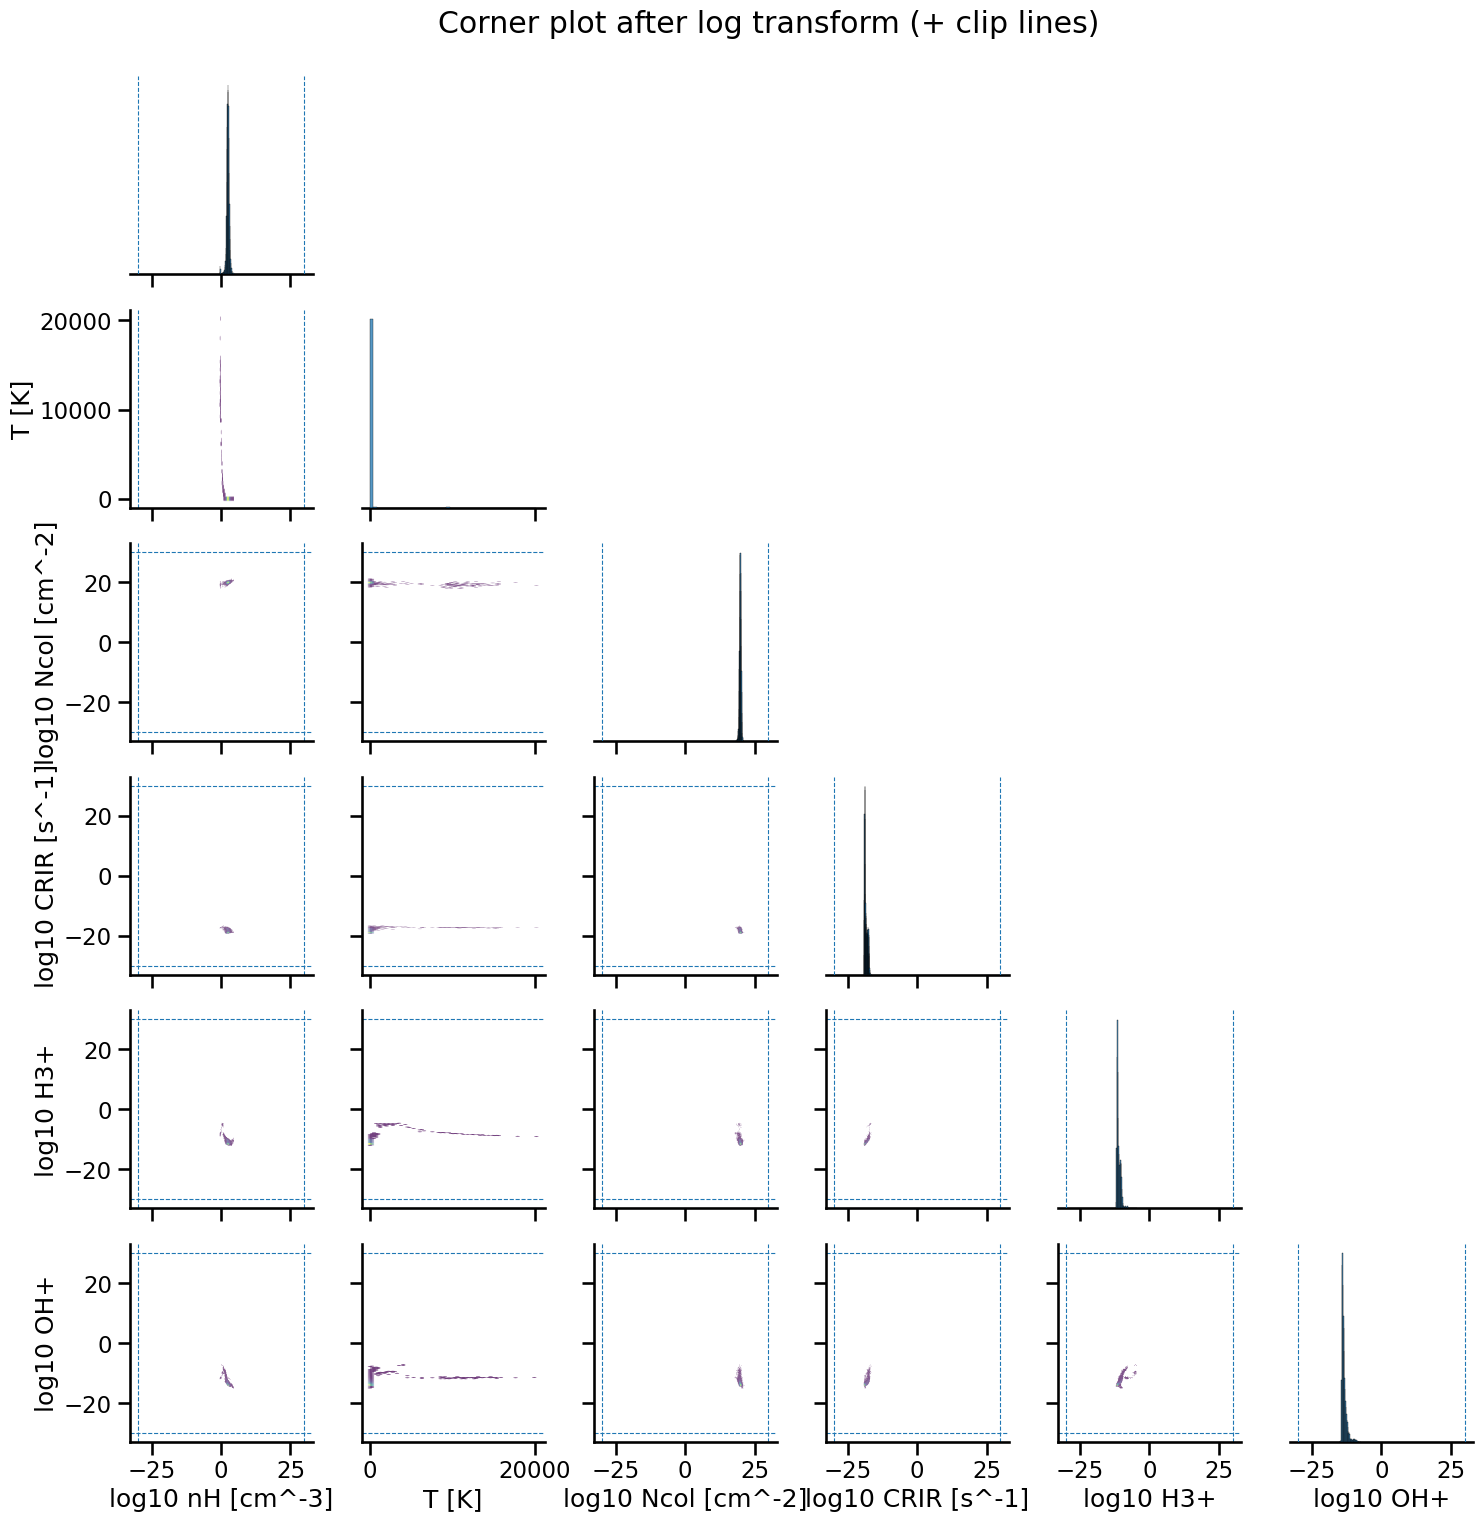

In [ ]:
# -----------------------------
# Corner plot using fast PairGrid hexbin
# -----------------------------
# Build log-transformed copies for plotting ONLY (no standardization here)
X_plot_t = torch.tensor(X_df.values, dtype=DTYPE)
Y_plot_t = torch.tensor(y_df.values, dtype=DTYPE)
X_loglin_plot, _ = preprocess_X_train(X_plot_t)   # applies log10 to nH/Ncol/CRIR and clips
Y_log_plot,  _   = preprocess_y_train(Y_plot_t)   # applies log10 to both targets and clips

# Assemble a dataframe with descriptive labels
plot_cols = ["log10 nH [cm^-3]", "T [K]", "log10 Ncol [cm^-2]", "log10 CRIR [s^-1]", "log10 H3+", "log10 OH+"]
XY_plot_np = torch.cat([X_loglin_plot, Y_log_plot], dim=1).cpu().numpy()
corner_plot_df = pd.DataFrame(XY_plot_np, columns=plot_cols)

# Downsample for speed (hexbin scales well; still cap for interactivity)
M = min(len(corner_plot_df), 20000)
corner_sample = corner_plot_df.sample(n=M, random_state=SEED)

# Fast PairGrid with hexbin on off-diagonals, hist on diagonals
import seaborn as sns, numpy as np, matplotlib.pyplot as plt
sns.set_context("talk")

# Which variables are log-clipped (for drawing clip lines)
logged_map = {
    "log10 nH [cm^-3]": True,
    "T [K]": False,
    "log10 Ncol [cm^-2]": True,
    "log10 CRIR [s^-1]": True,
    "log10 H3+": True,
    "log10 OH+": True,
}

# Hexbin mapper
def _hex(x, y, **k):
    ax = plt.gca()
    hb = ax.hexbin(x, y, gridsize=40, mincnt=1, linewidths=0)
    # rasterize to speed up rendering
    for coll in ax.collections:
        coll.set_rasterized(True)

# Build grid
g = sns.PairGrid(corner_sample, corner=True, diag_sharey=False)
g.map_lower(_hex)
g.map_diag(sns.histplot, bins=50, kde=False)

# Draw clip lines on axes where that variable was log-transformed
CL = CFG["clip_after_log"][0]; CH = CFG["clip_after_log"][1]

# Off-diagonal: vertical lines for log-x vars; horizontal lines for log-y vars
for i in range(1, len(g.y_vars)):
    for j in range(i):
        ax = g.axes[i, j]
        xname = g.x_vars[j]; yname = g.y_vars[i]
        if logged_map.get(xname, False):
            ax.axvline(CL, ls='--', lw=0.8)
            ax.axvline(CH, ls='--', lw=0.8)
        if logged_map.get(yname, False):
            ax.axhline(CL, ls='--', lw=0.8)
            ax.axhline(CH, ls='--', lw=0.8)

# Diagonals: vertical lines for log vars
for i, ax in enumerate(g.diag_axes):
    name = g.x_vars[i]
    if logged_map.get(name, False):
        ax.axvline(CL, ls='--', lw=0.8)
        ax.axvline(CH, ls='--', lw=0.8)

plt.suptitle("Corner plot after log transform (+ clip lines)", y=1.02)
plt.show()

In [ ]:
# @title
# -----------------------------
# Transforms (log10 + standardize)
# -----------------------------
@dataclass
class NormStats:
    x_mean: list
    x_std: list
    y_mean: list
    y_std: list
    x_log_mask: list  # which inputs were log-transformed
    y_log_mask: list  # which targets were log-transformed

def _safe_log10(t: torch.Tensor) -> torch.Tensor:
    return torch.log10(torch.clamp(t, min=1e-40))

def _clip(t: torch.Tensor, lo: float, hi: float) -> torch.Tensor:
    return torch.clamp(t, lo, hi)

def preprocess_X_train(X_raw: torch.Tensor) -> Tuple[torch.Tensor, np.ndarray]:
    X = X_raw.clone().to(DTYPE)
    log_mask = np.array(INPUT_LOG10_MASK, dtype=bool)
    for j, is_log in enumerate(log_mask):
        if is_log:
            X[:, j] = _safe_log10(X[:, j])
    X = _clip(X, CFG["clip_after_log"][0], CFG["clip_after_log"][1])
    return X, log_mask

def preprocess_y_train(Y_raw: torch.Tensor) -> Tuple[torch.Tensor, np.ndarray]:
    Y = Y_raw.clone().to(DTYPE)
    log_mask = np.array([True, True], dtype=bool)
    for j, is_log in enumerate(log_mask):
        if is_log:
            Y[:, j] = _safe_log10(Y[:, j])
    Y = _clip(Y, CFG["clip_after_log"][0], CFG["clip_after_log"][1])
    return Y, log_mask

def standardize(t: torch.Tensor, mean: torch.Tensor, std: torch.Tensor) -> torch.Tensor:
    return (t - mean) / torch.clamp(std, min=1e-12)

def destandardize(t: torch.Tensor, mean: torch.Tensor, std: torch.Tensor) -> torch.Tensor:
    return t * std + mean

def invert_y_to_original_space(y_std: torch.Tensor, stats: NormStats) -> torch.Tensor:
    y_mean = torch.tensor(stats.y_mean, dtype=DTYPE, device=y_std.device)
    y_stdv = torch.tensor(stats.y_std, dtype=DTYPE, device=y_std.device)
    y_log_mask = torch.tensor(stats.y_log_mask, dtype=torch.bool, device=y_std.device)
    y_log = destandardize(y_std, y_mean, y_stdv)
    y_out = y_log.clone()
    y_out[:, y_log_mask] = torch.pow(10.0, y_log[:, y_log_mask])
    return y_out

Saved normalization stats to: ./norm_stats.json


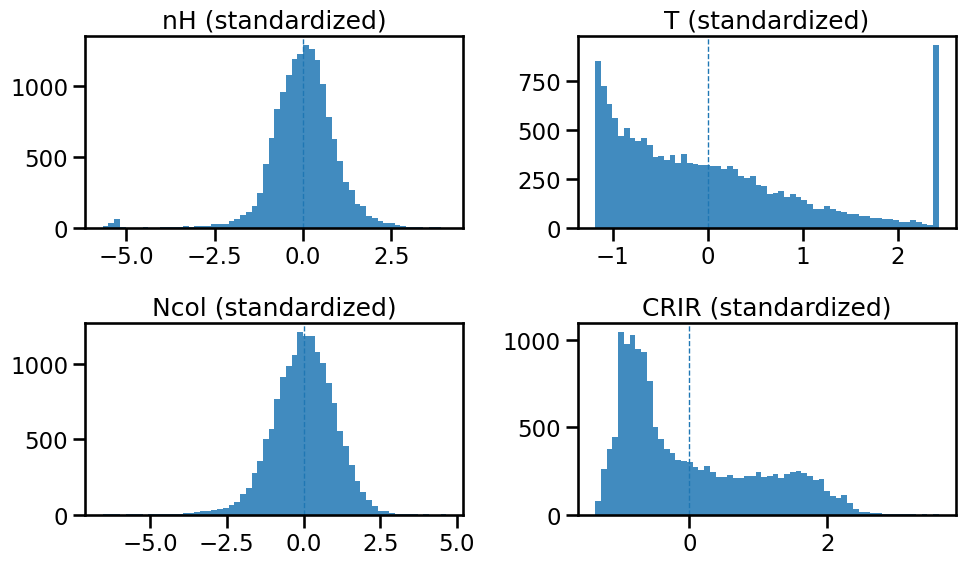

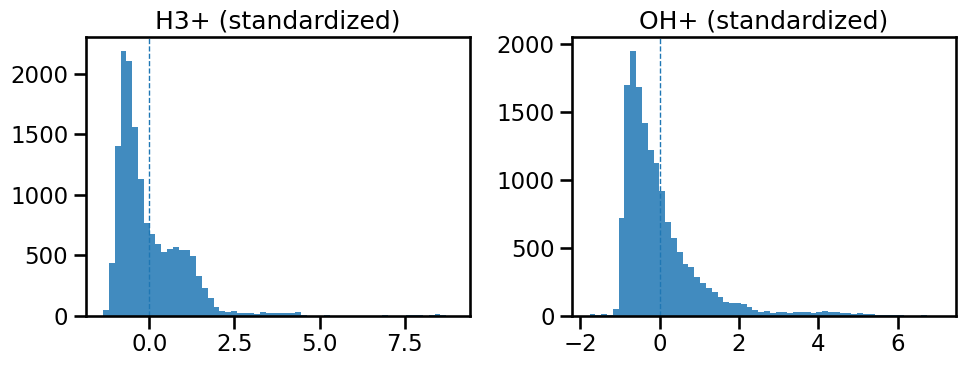

In [ ]:
# -----------------------------
# Dataset / Dataloaders
# -----------------------------
class TensorPairDataset(Dataset):
    def __init__(self, X: torch.Tensor, Y: torch.Tensor):
        self.X = X; self.Y = Y
    def __len__(self): return self.X.shape[0]
    def __getitem__(self, idx): return self.X[idx], self.Y[idx]

# Prepare tensors for split
X_all = x_train_tensor.detach().cpu().to(DTYPE)
Y_all = u_train_tensor.detach().cpu().to(DTYPE)

N = X_all.shape[0]
perm = torch.randperm(N, generator=torch.Generator().manual_seed(SEED))
X_all = X_all[perm]; Y_all = Y_all[perm]

n_train = int(CFG["split"]["train"] * N)
n_val   = int(CFG["split"]["val"]   * N)
n_test  = N - n_train - n_val

X_tr_raw, Y_tr_raw = X_all[:n_train],               Y_all[:n_train]
X_va_raw, Y_va_raw = X_all[n_train:n_train+n_val],  Y_all[n_train:n_train+n_val]
X_te_raw, Y_te_raw = X_all[n_train+n_val:],         Y_all[n_train+n_val:]

# Apply transforms BEFORE computing std stats (train only)
X_tr_loglin, x_log_mask = preprocess_X_train(X_tr_raw)
Y_tr_log,    y_log_mask = preprocess_y_train(Y_tr_raw)

x_mean = X_tr_loglin.mean(dim=0); x_std = X_tr_loglin.std(dim=0, unbiased=True)
y_mean = Y_tr_log.mean(dim=0);    y_std = Y_tr_log.std(dim=0, unbiased=True)

# Standardize all splits using TRAIN stats
def preprocess_full_X(X_raw: torch.Tensor) -> torch.Tensor:
    X_tmp, _ = preprocess_X_train(X_raw)
    return standardize(X_tmp, x_mean, x_std)

def preprocess_full_Y(Y_raw: torch.Tensor) -> torch.Tensor:
    Y_tmp, _ = preprocess_y_train(Y_raw)
    return standardize(Y_tmp, y_mean, y_std)

X_tr = preprocess_full_X(X_tr_raw); Y_tr = preprocess_full_Y(Y_tr_raw)
X_va = preprocess_full_X(X_va_raw); Y_va = preprocess_full_Y(Y_va_raw)
X_te = preprocess_full_X(X_te_raw); Y_te = preprocess_full_Y(Y_te_raw)

train_ds = TensorPairDataset(X_tr, Y_tr)
val_ds   = TensorPairDataset(X_va, Y_va)
test_ds  = TensorPairDataset(X_te, Y_te)

train_loader = DataLoader(train_ds, batch_size=CFG["batch_size"], shuffle=True,  pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=CFG["batch_size"], shuffle=False, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=CFG["batch_size"], shuffle=False, pin_memory=True)

# Save normalization stats for later inference
norm_stats = NormStats(
    x_mean=x_mean.tolist(), x_std=x_std.tolist(),
    y_mean=y_mean.tolist(), y_std=y_std.tolist(),
    x_log_mask=x_log_mask.tolist(), y_log_mask=y_log_mask.tolist(),
)
with open(CFG["paths"]["norm"], "w") as f:
    json.dump(norm_stats.__dict__, f, indent=2)
print(f"Saved normalization stats to: {CFG['paths']['norm']}")

# -----------------------------
# Post-standardization histograms (inputs + outputs)
# -----------------------------
# Use all data standardized with train stats for visualization
X_all_std = preprocess_full_X(X_all)
Y_all_std = preprocess_full_Y(Y_all)

# Inputs: 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(10,6))
axes = axes.ravel()
for j, ax in enumerate(axes):
    ax.hist(X_all_std[:, j].numpy(), bins=60, alpha=0.85)
    ax.axvline(0.0, ls='--', lw=1)
    ax.set_title(["nH","T","Ncol","CRIR"][j] + " (standardized)")
plt.tight_layout(); plt.show()

# Outputs: 1x2 grid
fig, axes = plt.subplots(1, 2, figsize=(10,4))
for j, ax in enumerate(axes):
    ax.hist(Y_all_std[:, j].numpy(), bins=60, alpha=0.85)
    ax.axvline(0.0, ls='--', lw=1)
    ax.set_title(["H3+","OH+"][j] + " (standardized)")
plt.tight_layout(); plt.show()

In [ ]:
# -----------------------------
# Model (4 -> 2000 -> 2000 -> 2000 -> 2000 -> 2)
# He/Kaiming uniform for ReLU; biases zero
# -----------------------------
class BehrensMLP(nn.Module):
    def __init__(self, in_dim: int = 4, hidden: int = 2000, out_dim: int = 2, num_hidden: int = 4):
        super().__init__()
        layers = []
        last = in_dim
        for _ in range(num_hidden):
            lin = nn.Linear(last, hidden, bias=True)
            nn.init.kaiming_uniform_(lin.weight, a=0.0, mode='fan_in', nonlinearity='relu')
            nn.init.zeros_(lin.bias)
            layers += [lin, nn.ReLU(inplace=True)]
            last = hidden
        out = nn.Linear(last, out_dim, bias=True)
        nn.init.kaiming_uniform_(out.weight, a=0.0, mode='fan_in', nonlinearity='linear')
        nn.init.zeros_(out.bias)
        layers += [out]
        self.net = nn.Sequential(*layers)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

model = BehrensMLP().to(DEVICE)

# Count & print parameters (should be ~12,020,002)
def count_params(m: nn.Module) -> int:
    return sum(p.numel() for p in m.parameters() if p.requires_grad)
print(f"Trainable parameters: {count_params(model):,d}  (expected ~12,020,002)")

# -----------------------------
# Loss, optimizer, scheduler, AMP
# -----------------------------
criterion = nn.MSELoss(reduction="mean")
optimizer = torch.optim.Adam(model.parameters(), **CFG["optim"])
scheduler = ReduceLROnPlateau(optimizer, mode="min", **CFG["scheduler"])
scaler = torch.amp.GradScaler("cuda", enabled=(DEVICE.type == "cuda"))

# -----------------------------
# Training / Evaluation loops
# -----------------------------

def run_epoch(loader, train_mode: bool) -> float:
    model.train() if train_mode else model.eval()
    total_loss, total_count = 0.0, 0
    for xb, yb in loader:
        xb = xb.to(DEVICE, non_blocking=True)
        yb = yb.to(DEVICE, non_blocking=True)
        if train_mode:
            optimizer.zero_grad(set_to_none=True)
            with torch.amp.autocast("cuda", enabled=(DEVICE.type == "cuda")):
                preds = model(xb)
                loss = criterion(preds, yb)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            with torch.no_grad(), torch.amp.autocast("cuda", enabled=(DEVICE.type == "cuda")):
                preds = model(xb)
                loss = criterion(preds, yb)
        bs = xb.size(0)
        total_loss += float(loss.detach().cpu()) * bs
        total_count += bs
    return total_loss / max(1, total_count)

best_val = float("inf"); best_state = None; epochs_no_improve = 0
train_losses = []
val_losses = []
for epoch in tqdm(range(1, CFG["max_epochs"] + 1)):
    train_loss = run_epoch(train_loader, train_mode=True)
    val_loss   = run_epoch(val_loader,   train_mode=False)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    scheduler.step(val_loss)
    if val_loss < best_val - 1e-8:
        best_val = val_loss
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
    if epoch % 10 == 0 or epoch == 1:
        lr = optimizer.param_groups[0]["lr"]
        print(f"[{epoch:4d}] train={train_loss:.6f}  val={val_loss:.6f}  lr={lr:.2e}")
    if epochs_no_improve >= CFG["early_stop_patience"]:
        print(f"Early stopping at epoch {epoch}. Restoring best weights (val={best_val:.6f}).")
        break

if best_state is not None:
    model.load_state_dict(best_state)

torch.save(model.state_dict(), CFG["paths"]["model"])
print(f"Saved best model to: {CFG['paths']['model']}")

Trainable parameters: 12,020,002  (expected ~12,020,002)


  0%|          | 1/500 [00:01<14:34,  1.75s/it]

[   1] train=16.087245  val=0.101077  lr=1.00e-03


  2%|▏         | 10/500 [00:13<10:10,  1.25s/it]

[  10] train=0.041305  val=0.118500  lr=1.00e-03


  4%|▍         | 20/500 [00:25<09:31,  1.19s/it]

[  20] train=0.027862  val=0.034456  lr=5.00e-04


  6%|▌         | 30/500 [00:36<09:33,  1.22s/it]

[  30] train=0.022346  val=0.033954  lr=2.50e-04


  8%|▊         | 40/500 [00:47<08:40,  1.13s/it]

[  40] train=0.018686  val=0.036270  lr=1.25e-04


 10%|█         | 50/500 [00:59<08:14,  1.10s/it]

[  50] train=0.015060  val=0.033069  lr=6.25e-05


 12%|█▏        | 60/500 [01:10<08:08,  1.11s/it]

[  60] train=0.013833  val=0.031609  lr=3.13e-05


 14%|█▍        | 70/500 [01:22<07:57,  1.11s/it]

[  70] train=0.011859  val=0.031232  lr=7.81e-06


 15%|█▍        | 74/500 [01:27<08:24,  1.18s/it]

Early stopping at epoch 75. Restoring best weights (val=0.031065).
Saved best model to: ./model.pth


In [ ]:
# -----------------------------
# Metrics in standardized and original spaces
# -----------------------------
@torch.no_grad()
def evaluate(loader) -> Dict[str, float]:
    model.eval()
    mse_std_sum, mse_orig_sum, mae_orig_sum, n = 0.0, 0.0, 0.0, 0
    for xb, yb in loader:
        xb = xb.to(DEVICE); yb = yb.to(DEVICE)
        preds_std = model(xb)
        # standardized MSE (sum over 2 targets, averaged over batch)
        mse_std_sum += torch.mean((preds_std - yb) ** 2, dim=0).sum().item() * xb.size(0)
        # invert to original space for MSE/MAE
        preds_orig = invert_y_to_original_space(preds_std, norm_stats)
        y_mean_t = torch.tensor(norm_stats.y_mean, dtype=DTYPE, device=DEVICE)
        y_std_t  = torch.tensor(norm_stats.y_std,  dtype=DTYPE, device=DEVICE)
        y_log_mask = torch.tensor(norm_stats.y_log_mask, dtype=torch.bool, device=DEVICE)
        y_log = destandardize(yb, y_mean_t, y_std_t)
        y_orig = y_log.clone(); y_orig[:, y_log_mask] = torch.pow(10.0, y_log[:, y_log_mask])
        mse_orig_sum += torch.mean((preds_orig - y_orig) ** 2, dim=0).sum().item() * xb.size(0)
        mae_orig_sum += torch.mean(torch.abs(preds_orig - y_orig), dim=0).sum().item() * xb.size(0)
        n += xb.size(0)
    return {
        "mse_std":  mse_std_sum / max(1, n),
        "mse_orig": mse_orig_sum / max(1, n),
        "mae_orig": mae_orig_sum / max(1, n),
    }

metrics_train = evaluate(train_loader)
metrics_val   = evaluate(val_loader)
metrics_test  = evaluate(test_loader)

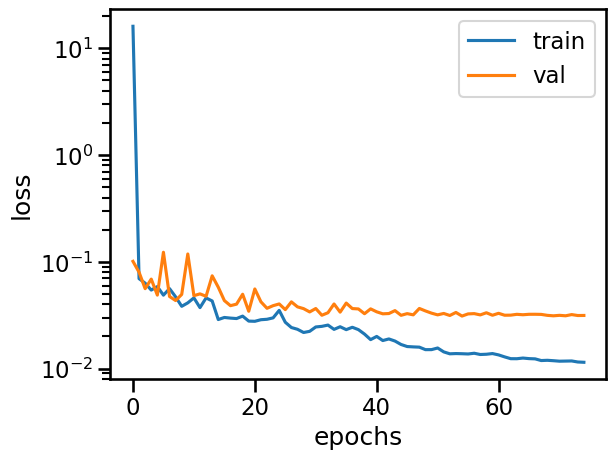

In [ ]:
plt.plot(train_losses, label="train")
plt.plot(val_losses,   label="val")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.yscale('log')

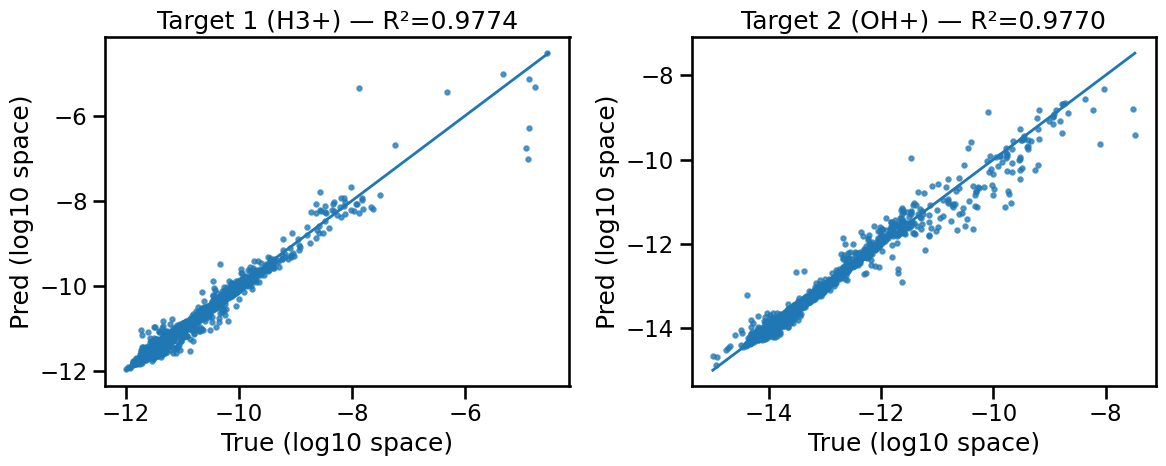


=== Split sizes ===
Train: 9192  |  Val: 2298  |  Test: 3830

=== Final metrics ===
Train: {'mse_std': 0.025554548499958217, 'mse_orig': 1.3510305166638045e-13, 'mae_orig': 1.2964698777545106e-08}
Val:   {'mse_std': 0.06210766768356942, 'mse_orig': 1.1473022184452352e-13, 'mae_orig': 2.1214245925149223e-08}
Test:  {'mse_std': 0.044198622980566, 'mse_orig': 1.8668702595241872e-13, 'mae_orig': 1.8469200466093768e-08}

Helpers ready: predict_abundances(X_raw) -> original-space predictions
Saved files: ./model.pth , ./norm_stats.json


In [ ]:
# -----------------------------
# Parity plots (per target) + R² in LOG space
# -----------------------------
@torch.no_grad()
def get_preds_and_truth_log(loader):
    """
    Return predictions and truths in *log10 space* (de-standardized).
    No inversion to original space here.
    """
    model.eval()
    preds_all, truth_all = [], []
    y_mean_t = torch.tensor(norm_stats.y_mean, dtype=DTYPE, device=DEVICE)
    y_std_t  = torch.tensor(norm_stats.y_std,  dtype=DTYPE, device=DEVICE)

    for xb, yb in loader:
        xb = xb.to(DEVICE); yb = yb.to(DEVICE)
        preds_std = model(xb)                          # standardized log10
        preds_log = destandardize(preds_std, y_mean_t, y_std_t)  # -> log10 space
        y_true_log = destandardize(yb, y_mean_t, y_std_t)        # -> log10 space

        preds_all.append(preds_log.cpu().numpy())
        truth_all.append(y_true_log.cpu().numpy())

    return np.vstack(preds_all), np.vstack(truth_all)

def r2_score_np(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true, axis=0)) ** 2)
    return 1.0 - ss_res / max(ss_tot, 1e-30)

# Collect in log10 space
preds_log, truth_log = get_preds_and_truth_log(test_loader)

# Plot in log space (linear axes, since values are already log10)
fig, axes = plt.subplots(1, 2, figsize=(12,5))
names = ["Target 1 (H3+)", "Target 2 (OH+)"]
for j, ax in enumerate(axes):
    r2j = r2_score_np(truth_log[:, [j]], preds_log[:, [j]])
    ax.scatter(truth_log[:, j], preds_log[:, j], s=10, alpha=0.7)
    lo = float(min(truth_log[:, j].min(), preds_log[:, j].min()))
    hi = float(max(truth_log[:, j].max(), preds_log[:, j].max()))
    ax.plot([lo, hi], [lo, hi], lw=2)
    ax.set_xlabel("True (log10 space)")
    ax.set_ylabel("Pred (log10 space)")
    ax.set_title(f"{names[j]} — R²={r2j:.4f}")
plt.tight_layout(); plt.show()

# -----------------------------
# Print sizes & metrics table
# -----------------------------
print("\n=== Split sizes ===")
print(f"Train: {n_train}  |  Val: {n_val}  |  Test: {n_test}")
print("\n=== Final metrics ===")
print("Train:", {k: float(v) for k, v in metrics_train.items()})
print("Val:  ", {k: float(v) for k, v in metrics_val.items()})
print("Test: ", {k: float(v) for k, v in metrics_test.items()})

# -----------------------------
# Inference helper
# -----------------------------
@torch.no_grad()
def predict_abundances(X_raw: torch.Tensor) -> torch.Tensor:
    """Apply the exact preprocessing, run the model, and return predictions in original target space."""
    model.eval(); X_raw = X_raw.to(DTYPE)
    X_tmp, _ = preprocess_X_train(X_raw)
    X_std = standardize(X_tmp,
                        torch.tensor(norm_stats.x_mean, dtype=DTYPE),
                        torch.tensor(norm_stats.x_std,  dtype=DTYPE))
    X_std = X_std.to(DEVICE)
    preds_std = model(X_std)
    return invert_y_to_original_space(preds_std, norm_stats).cpu()

print("\nHelpers ready: predict_abundances(X_raw) -> original-space predictions")
print(f"Saved files: {CFG['paths']['model']} , {CFG['paths']['norm']}")